In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


%matplotlib inline

In [2]:
train_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_train.csv', index_col=0)
test_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test1.csv', index_col=0)
submit1_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test2.csv', index_col=0)
submit2_df = pd.read_csv('https://grantmlong.com/data/SE_rents2018_test3.csv', index_col=0)

In [3]:
train_df.columns

Index(['addr_unit', 'building_id', 'bedrooms', 'bathrooms', 'size_sqft',
       'created_at', 'addr_street', 'addr_city', 'addr_zip', 'addr_lat',
       'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built', 'min_to_subway',
       'has_doorman', 'has_elevator', 'has_fireplace', 'has_dishwasher',
       'is_furnished', 'has_gym', 'allows_pets', 'has_washer_dryer',
       'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool', 'has_garden',
       'has_childrens_playroom', 'rent', 'no_fee', 'description',
       'neighborhood', 'borough', 'unit', 'floornumber', 'line'],
      dtype='object')

In [4]:
train_df.sample(5).transpose()

rental_id,7251370,7413442,7366156,7368307,7342642
addr_unit,#14E,#1,#12,#4,#31F
building_id,33898,113449,18714253,647302,77029
bedrooms,1,0,2,1,1
bathrooms,1,1,1,1,1
size_sqft,880,700,520,650,1115
created_at,2018-06-07 18:43:28,2018-07-26 16:51:02,2018-07-13 21:38:33,2018-07-15 14:06:50,2018-07-07 16:19:08
addr_street,425 WEST 23 STREET,341 WEST 122 STREET,240 EAST 13 STREET,325 76 STREET,265 EAST 66 STREET
addr_city,New York,New York,New York,Brooklyn,New York
addr_zip,10011,10027,10003,11209,10065
addr_lat,40.7473,40.8092,40.7318,40.6308,40.7658


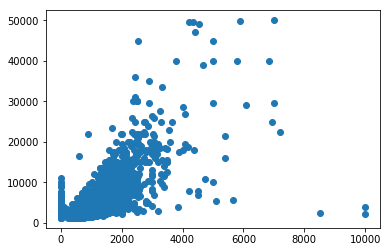

In [5]:
plt.scatter(train_df['size_sqft'],train_df['rent'])

In [6]:
#Had to remove features with strings as the type i.e. 'addr_city', 'neighborhood', 'borough'
#Might have to try turning them into numbers to find out how important they are
features = ['bedrooms', 'bathrooms', 'size_sqft', 'addr_zip', 'bin', 'bbl',
                    'floor_count', 'has_doorman', 'has_elevator',
                    'has_fireplace', 'has_dishwasher','is_furnished', 'has_gym', 'allows_pets',
                    'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge', 'has_pool',
                    'has_garden', 'has_childrens_playroom', 'no_fee', 'rent']

#Most important features (comment it out to test every feature)
features = ['size_sqft', 'bbl', 'bathrooms', 'rent']

print('Train NaNs:', train_df[features].isna().sum(), sep='\n')
print('\n')
print('Test NaNs:', test_df[features].isna().sum(), sep='\n')

train_features = train_df[features].dropna()
train_target = train_features['rent']
train_features = train_features.drop(labels='rent', axis=1)
test_features = test_df[features]
test_target = test_features['rent']
test_features = test_features.drop(labels='rent', axis=1)

Train NaNs:
size_sqft    0
bbl          0
bathrooms    0
rent         0
dtype: int64


Test NaNs:
size_sqft    0
bbl          0
bathrooms    0
rent         0
dtype: int64


In [7]:
lr = LinearRegression()
lr.fit(train_features, train_target)
test_pred = lr.predict(test_features)
cv_results = cross_val_score(lr, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('LinearRegression', mean_squared_error(test_target, test_pred), cv_results, np.mean(cv_results))

dt = DecisionTreeRegressor()
dt.fit(train_features, train_target)
test_pred = dt.predict(test_features)
cv_results = cross_val_score(dt, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('DecisionTreeRegressor', mean_squared_error(test_target, test_pred), cv_results, np.mean(cv_results))

gb = GradientBoostingRegressor()
gb.fit(train_features, train_target)
test_pred = gb.predict(test_features)
cv_results = cross_val_score(gb, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('GradientBoostingRegressor', mean_squared_error(test_target, test_pred), cv_results, np.mean(cv_results))

rf = RandomForestRegressor()
rf.fit(train_features, train_target)
test_pred = rf.predict(test_features)
cv_results = cross_val_score(rf, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('RandomForestRegressor', mean_squared_error(test_target, test_pred), cv_results, np.mean(cv_results))

#To get the feature importances for linear regression scale the features and then use .coef_
#importances for lr are in magnitude while others are in percentage
#I haven't scaled the features so this code doesn't really tell you much
importances = lr.coef_
print('\nLinear Regression:')
for i in range(len(importances)):
    print('\n',features[i], importances[i])
    
importances = dt.feature_importances_
print('\nDecision Tree:')
for i in range(len(importances)):
    print('\n',features[i], importances[i]*100)
    
importances = gb.feature_importances_
print('\nGradient Boosting:')
for i in range(len(importances)):
    print('\n',features[i], importances[i]*100)
    
importances = rf.feature_importances_
print('\nRandom Forest:')
for i in range(len(importances)):
    print('\n',features[i], importances[i]*100)
    
#GradientBoostingRegressor or RandomForestRegressor seems to give us the best score so far, further testing with hyperparameters is needed

LinearRegression 3586336.3066365807 [-4245428.15010455 -3455396.29845153 -3487234.67072485 -3946021.59294055
 -2216641.46957342] -3470144.4363589785
DecisionTreeRegressor 2695088.0296032988 [-2797197.26949909 -2203661.03190209 -2813646.20052847 -1744101.69969221
 -1810834.41455316] -2273888.123235003
GradientBoostingRegressor 2037391.2156502705 [-1798189.25314747 -1460499.17672819 -1999237.58369992 -1472966.10644743
 -1015354.46313495] -1549249.3166315937
RandomForestRegressor 1921974.3108695669 [-1636226.54294961 -1666250.26681307 -1973055.76645746 -1655674.96014216
 -1057426.45457592] -1597726.7981876442

Linear Regression:

 size_sqft 2.6297502245284408

 bbl -7.234851782892026e-07

 bathrooms 1629.862188821999

Decision Tree:

 size_sqft 64.50298307255198

 bbl 25.988325790247522

 bathrooms 9.5086911372005

Gradient Boosting:

 size_sqft 45.60336712509924

 bbl 44.08985879137791

 bathrooms 10.306774083522855

Random Forest:

 size_sqft 62.97781913946429

 bbl 26.093503420507037



In [8]:
def testHyperparameter(param_grid):
    results = {}
    hp_name = list(param_grid.keys())[0]
    hp_values = list(param_grid.values())[0]
    
    # Create decision tree model and tune hyperparameter using GridSearchCV
    decision_tree = DecisionTreeRegressor()
    dt_cv = GridSearchCV(dt, param_grid, cv=5)
    dt_cv.fit(train_features, train_target)
    results['best_param'] = dt_cv.best_params_
    results['best_score'] = dt_cv.best_score_
    
    # Grab mean test/train score of 5 splits
    mean_test = dt_cv.cv_results_['mean_test_score']
    mean_train = dt_cv.cv_results_['mean_train_score']

    # Plot mean test/train AUC score against hyperparameter values
    line1, = plt.plot(hp_values, mean_test, 'b', label='Test AUC')
    line2, = plt.plot(hp_values, mean_train, 'r', label='Train AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC Score')
    plt.xlabel(hp_name)
    plt.show()
    
    print(results)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


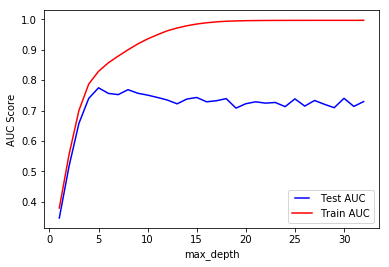

{'best_param': {'max_depth': 5}, 'best_score': 0.7749171180616824}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


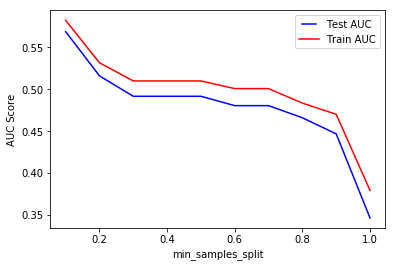

{'best_param': {'min_samples_split': 0.1}, 'best_score': 0.5688456246763185}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


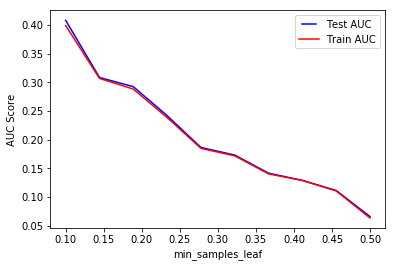

{'best_param': {'min_samples_leaf': 0.1}, 'best_score': 0.4082829298498315}


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


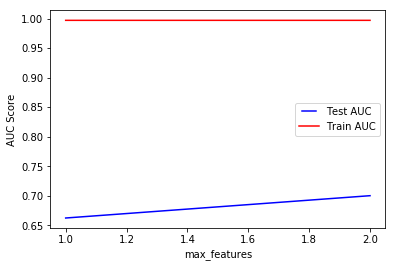

{'best_param': {'max_features': 2}, 'best_score': 0.7003433107534048}


In [9]:
# Tuning individual hyperparameters for decision tree regressor 
param_grids = []

# Hyperparameter 1: max_depth -> indicates depth of tree; 
# Testing range of 1 to 32
max_depth_values = np.arange(1, 33)
param_grids.append({'max_depth': max_depth_values})

# Hyperparameter 2: min_samples_split <- minimum number of samples required to split a node
# Testing range from 10% to 100%
min_samples_split = np.linspace(0.1, 1.0, 10, endpoint=True)
param_grids.append({'min_samples_split': min_samples_split})

# Hyperparameter 3: min_samples_leaf <- minimum number of samples required at each leaf node
# Testing range from 10% to 50%
min_samples_leaf = np.linspace(0.1, 0.5, 10, endpoint=True)
param_grids.append({'min_samples_leaf': min_samples_leaf})

# Hyperparameter 4: max_features <- max number of features to test
# Testing range from 1 to 1 less than the number of features in the df
max_features = list(range(1,train_features.shape[1]))
param_grids.append({'max_features': max_features})

for hyperparameter in param_grids:
    testHyperparameter(hyperparameter)


In [10]:
# Testing all 4 hyperparameters together to find the best combination
total_param_grid = {
    'max_depth': np.arange(1,100),
    'min_samples_split': np.linspace(.1, 1, 10, endpoint=True),
    'min_samples_leaf': np.linspace(.1, .5, 10, endpoint=True),
    'max_features': max_features
}

dtr = DecisionTreeRegressor()
dtr_cv = RandomizedSearchCV(dtr, total_param_grid, cv=5, n_iter=1000, n_jobs=-1)
dtr_cv.fit(train_features, train_target)
print(dtr_cv.best_params_)
print(dtr_cv.best_score_)
print(dtr_cv.best_estimator_)

{'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_features': 2, 'max_depth': 16}
0.4257232549277119
DecisionTreeRegressor(criterion='mse', max_depth=16, max_features=2,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=0.1,
           min_samples_split=0.2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


In [11]:
# Results of predicting rent on test set using optimized decision tree
optimized_dt = dtr_cv.best_estimator_
test_pred = optimized_dt.predict(test_features)
cv_results = cross_val_score(dt, train_features, train_target, cv=5, scoring = 'neg_mean_squared_error')
print('DecisionTreeRegressor')
print('Mean Squared Error: ', mean_squared_error(test_target, test_pred))
print("CV Results: ", cv_results)
print("Mean CV Results: ", np.mean(cv_results))

DecisionTreeRegressor
Mean Squared Error:  4421355.686948194
CV Results:  [-2966250.3191403  -2104334.30482454 -2749289.50172928 -1783309.93622288
 -1770220.06828869]
Mean CV Results:  -2274680.826041137
